# MCMC 2.1: application for parameter estimation

In this notebook, we will use a Markov Chain based on the Metropolis-Hastings algorithm to estimate neutrino oscillation parameters.

The experiment setup simulated in this notebook is the one of the Deep Underground Neutrino Experiment (DUNE). DUNE measures neutrino oscillations by observing the transition of a muon (anti)neutrino beam created in Fermilab toward electron and tau (antineutrinos) in the far detector located 1'300 km away, in the Sanford Underground Research Facility. 

In [1]:
### Import necessary python packages

# math package
import numpy as np
import scipy.stats as stats

# plotting packages
import matplotlib as mpl
from matplotlib import pyplot as plt

# input files reading package 
import json

# data container package
import pandas as pd

# get the time
from datetime import datetime
import time


usetex = True

In [2]:
### Setup plot options

plt.rcParams["font.family"] = "serif"
plt.rcParams["mathtext.fontset"] = "dejavuserif"


## 1. Obtain the neutrino flux

The input is the charged-current event rate of neutrino interactions in the DUNE far detector. The event rate has been obtained from the ancillary files published at: https://arxiv.org/abs/2103.04797

In [3]:
### Function to read a JSON with several dictionaries separated by a new line

def json_reader(filename):
    with open(filename) as f:
        for line in f:
            yield json.loads(line)


In [4]:
### Read JSON file

flux_file = "dune_flux_hist.json"

flux_data = list(json_reader(flux_file))
len(flux_data), flux_data[0].keys()


(144,
 dict_keys(['file', 'config', 'nu', 'flux', 'osc', 'bins', 'counts', 'xaxis_title', 'yaxis_title']))

### 1.1 Unoscillated event rate

The input is the charged-current event rate of neutrino interactions in the DUNE far detector. The event rate has been obtained from the ancillary files published at: https://arxiv.org/abs/2103.04797

In [5]:
### Select dictionary for FD, neutrino mode, muon neutrino unoscillated event rate

config = 'flux_dune_neutrino_FD'
nu_type = 'numu'
flux_type = 'cceventrate'
osc = ''

flux_data_numode_fd = [f for f in flux_data if f['config'] == config]
flux_data_numode_fd_numu = [f for f in flux_data_numode_fd if f['nu'] == nu_type]
flux_data_numode_fd_numu_ccrate = [f for f in flux_data_numode_fd_numu if f['flux'] == flux_type]
flux_data_numode_fd_numu_ccrate_unosc = [f for f in flux_data_numode_fd_numu_ccrate if f['osc'] == osc]

evt_rate_unosc = flux_data_numode_fd_numu_ccrate_unosc[0]
evt_rate_unosc.keys()

dict_keys(['file', 'config', 'nu', 'flux', 'osc', 'bins', 'counts', 'xaxis_title', 'yaxis_title'])

In [6]:
### Select dictionary for FD, neutrino mode, muon neutrino oscillated event rate

config = 'flux_dune_neutrino_FD'
nu_type = 'numu'
flux_type = 'cceventrate'
osc = 'osc'

flux_data_numode_fd = [f for f in flux_data if f['config'] == config]
flux_data_numode_fd_numu = [f for f in flux_data_numode_fd if f['nu'] == nu_type]
flux_data_numode_fd_numu_ccrate = [f for f in flux_data_numode_fd_numu if f['flux'] == flux_type]
flux_data_numode_fd_numu_ccrate_osc = [f for f in flux_data_numode_fd_numu_ccrate if f['osc'] == osc]

evt_rate_osc = flux_data_numode_fd_numu_ccrate_osc[0]
evt_rate_osc.keys()

dict_keys(['file', 'config', 'nu', 'flux', 'osc', 'bins', 'counts', 'xaxis_title', 'yaxis_title'])

### 1.2 Oscillated event rate

We will use as model the simplified case of 2 neutrino flavours, the neutrino oscillation "appearance" probability is: 
$$ P_{\nu_{\mu} \rightarrow \nu_e} \ = \ \sin^2 (2\theta) \ \sin^2 \left( \frac{\Delta m^2 L}{4E} \right) $$
with: 
$$ \sin^2 \left( \frac{\Delta m^2 L}{4E} \right) \ \simeq \ \sin^2 \left( 1.27 \frac{\Delta m^2 [eV^2] \ L[km]}{E[GeV]} \right) $$
so the "disappearance" probability is: 
$$ P_{\nu_{\mu} \rightarrow \nu_{\mu}} \ = 1 - P_{\nu_{\mu} \rightarrow \nu_e} $$

The oscillation parameters are the mixing angle $\theta$ and the square of mass difference $\Delta m^2$. We want to estimate them using the histograms that we extracted.

In [7]:
### Define the oscillation probability

def osc_proba(E, theta=np.pi/4, Dm2=2.2e-3, L=1300):
    sin1 = np.sin(2*theta)**2
    sin2 = np.sin(1.27 * Dm2 * L / E)**2
    return 1 - sin1 * sin2

In [8]:
### Function to apply the oscillation to the unoscillated histogram 

def compute_osc_histo(theta, Dm2, hist): 

    # we will take the energy at the bin center
    bin_centers = []
    evt_rate_osc = [0]

    # loop over bins
    for i_b in np.arange(1, len(hist['bins'])):
        bin_centers.append(hist['bins'][i_b] - ((hist['bins'][i_b] - hist['bins'][i_b-1])/2))
        evt_rate_osc.append(hist['counts'][i_b] *20*1.47e21* osc_proba(bin_centers[-1], theta, Dm2))
    
    return evt_rate_osc

In [9]:
### Apply the oscillation to the unoscillated histogram and plot at the result

theta_true = np.pi/4
Dm2_true = 2.2e-3

evt_rate_osc_true = compute_osc_histo(theta_true, Dm2_true, evt_rate_unosc)


### 1.3 Compare the event rates

We will now compare the unoscillated and oscillated event rate. 

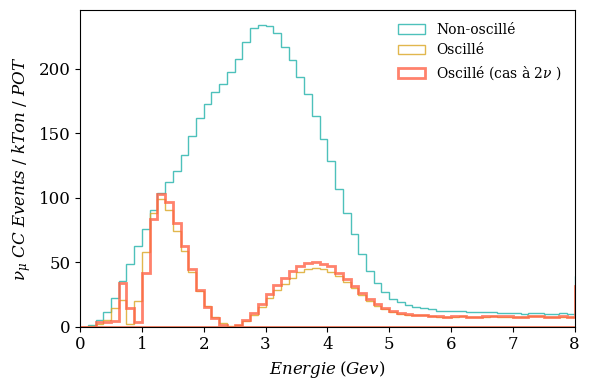

In [16]:
### Plot the fluxes

fig, (ax) = plt.subplots(nrows=1, ncols=1, figsize=(6,4), tight_layout=True)

# unoscillated rate from the DUNE ancillary file
ax.hist(evt_rate_unosc['bins'][:-1], bins=evt_rate_unosc['bins'], weights=[rate * 20 * 1.47e21 for rate in evt_rate_unosc['counts'][:-1]],
        color=None, edgecolor='lightseagreen', fill=False, lw=1, ls = '-', 
        histtype= "stepfilled", alpha= 0.8, label= 'Non-oscillé')

# oscillated rate from the DUNE ancillary file
ax.hist(evt_rate_osc['bins'][:-1], bins=evt_rate_osc['bins'], weights=[rate * 20 * 1.47e21 for rate in evt_rate_osc['counts'][:-1]],
        color=None, edgecolor='goldenrod', fill=False, lw=1, ls = '-', 
        histtype= "stepfilled", alpha= 0.8, label= 'Oscillé')

# oscillated rate computed with the 2-neutrino formula
ax.hist(evt_rate_unosc['bins'], bins=evt_rate_unosc['bins'], weights=[rate for rate in evt_rate_osc_true],
        color=None, edgecolor='tomato', fill=False, lw=2, ls = '-', 
        histtype= "stepfilled", alpha= 0.8, label= r'Oscillé (cas à 2$\nu$ )')

# title and axes
#ax.set_title(r'Charged-current $\nu_{\mu}$ event rate in the DUNE far detector')
ax.set_xlim([0, 8])
ax.set_xlabel(r'$Energie \: (Gev)$', fontsize=12)
ax.set_ylabel(r'$' + evt_rate_unosc['yaxis_title'].replace('#', '\\').replace(' ', ' \ ') +'$', fontsize=12)
plt.tick_params(axis = 'both', labelsize = 12)
ax.legend(frameon=False)

plt.savefig('DUNE_histo.png')

## 2. Set up the Markov Chain

We will use a Markov Chain to sample the posterior probability of the $\theta$ and $\Delta m^2$ parameters. The MCMC process at each step is: 
- throw a value of $\theta$ and $\Delta m^2$: $\{\theta_i, \Delta m^2_i \}$
- compute the oscillation probability for those parameter value at the DUNE energy $E_j$: $P_{\nu_{\mu} \rightarrow \nu_e}(\theta_i, \Delta m^2_i, E_j)$
- apply the oscillation probability to the unoscillated histogram: $ N_{osc(i)}(E_j) =  N_{unosc}(E_j) \times P_{\nu_{\mu} \rightarrow \nu_e}(\theta_i, \Delta m^2_i, E_j ) $
- compute the likelihood between the generated oscillated histogram and the one extracted from the file: 
- compute the Metropolis-Hastings ratio $r_i$ between the likelihood at this step and the likelihood at the previous step
- apply the acceptance function $A_i$
- redo until reaching the desired number of steps

### 2.1 Define the target distribution

The target distribution is the posterior probability of the $\theta$ and $\Delta m^2$ parameters. The MCMC will sample:  
$$ P(\theta, \Delta m^2 | \vec{D}) = P(\vec{D} | \theta, \Delta m^2) \ P(\theta, \Delta m^2) $$
where 
- $ P(\theta, \Delta m^2 | \vec{D}) $ is the posterior probability 
- $ P(\vec{D} | \theta, \Delta m^2) $ is the likelihood 
- $P(\theta, \Delta m^2)$ is the prior probability on the parameters $\theta$ and  $\Delta m^2$ 

**2.1.1 Prior probability**

We use a uniform prior probability on $\theta$ and $\Delta m^2$: 
$$ P(\theta) = \sqcap(-\pi/2, \pi/2) $$
$$ P(\Delta m^2) = \sqcap(0, 0.01) $$

defined as: 
- $P(\theta) = 1$ if $\theta \in [-\pi/2, \pi/2]$
- $P(\Delta m^2) = 1$ if $\Delta m^2 \in [0, 10^{-2}]$
- $P(\theta, \Delta m^2) = 0$ elsewehere


In [11]:
def print_progress_bar(iteration, total, prefix='', suffix='', decimals=1, length=50, fill='█'):
    """
    Affiche une barre de progression dans la console.
    
    :param iteration: Itération actuelle (int)
    :param total: Total des itérations (int)
    :param prefix: Préfixe de la barre (str)
    :param suffix: Suffixe de la barre (str)
    :param decimals: Nombre de décimales dans le pourcentage (int)
    :param length: Longueur de la barre de progression (int)
    :param fill: Caractère de remplissage de la barre (str)
    """
    percent = ("{0:." + str(decimals) + "f}").format(100 * (iteration / float(total)))
    filled_length = int(length * iteration // total)
    bar = fill * filled_length + '-' * (length - filled_length)
    print(f'\r{prefix} |{bar}| {percent}% {suffix}', end='\r')
    # Print New Line on Complete
    if iteration == total:
        print()

In [12]:
### Prior on theta
def prior_theta(theta):
    if 0 <= theta <= np.pi/2:
        return 1
    else:
        return 0

In [13]:
### Prior on Dm2
def prior_Dm2(Dm2):
    if 0 <= Dm2 <= 10**(-2):
        return 1
    else:
        return 0

**2.1.2 Likelihood function**

As we compare histogram, we use $\mathcal{L}_i = exp(\ln(\mathcal{L}_i)) $ where $\ln(\mathcal{L}_i)$ is the log-likelihood ratio: 
$$-\ln(\mathcal{L}_i) = \sum_{j=1}^{N \ bins} N^H_{i,j}(\theta_i, \Delta m^2_i) -  N^D_{i,j} + N^D_{i,j} \ ln \left( \frac{N^D_{i,j}}{N^H_{i,j}(\theta_i, \Delta m^2_i)} \right) $$

with $N^D_{i,j}$ the number of event in each bin $j$ of the true histogram, and $N^H_{i,j}(\theta_i, \Delta m^2_i)$ the number of event in each bin $j$  of the computed histogram at this step $i$ 

In [14]:
### Compute the likelihood
def ln_likelihood(data):
    ln_L = 0
    for i in range(len(data)):
        #print("i :", i, "data[i] :", data[i], 'evt_rate_osc_true[i]', evt_rate_osc_true[i])
        if (data[i] != 0) and (evt_rate_osc_true[i] != 0):
            ln_L += data[i] - evt_rate_osc_true[i] + evt_rate_osc_true[i] * np.log(evt_rate_osc_true[i] / data[i])
            #print("log :", np.log(evt_rate_osc_true[i] / data[i]))
            #print("ln_L", ln_L)
    return ln_L

print(ln_likelihood(compute_osc_histo(np.pi/4, 2.2e-3, evt_rate_unosc)))

0.0


In [15]:
ln_likelihood(compute_osc_histo(np.pi/4,2.2e-3,evt_rate_unosc))

0.0

**2.1.3 Posterior probability**

We compute the unnormed posterior probability (ignoring the normalisation factor $1/P(D)$ as it cancelled out in the Metropolis-Hastings ratio): 
$$P(\theta_i, \Delta m^2_i | D)_{un} = \mathcal{L}_i \  P(\theta_i, \Delta m^2_i) $$

In [16]:
### Compute the posterior probability
def posterior_prob(ln_likelihood, theta, Dm2):
    return np.exp(-ln_likelihood) * prior_theta(theta) * prior_Dm2(Dm2)

### 2.2 Jump function

We throw a value of $\theta$ at the step $i$ with a multvariate normal jump function: 
$$J (\theta_ i, \Delta m^2_i | \theta_{i-1}, \Delta m^2_{i-1}) = \mathcal{N}(\{ \theta_{i-1},  \Delta m^2_{i-1} \} , \Sigma_{\theta, \Delta m^2})$$ 
where $\Sigma = diag(\sigma_{\theta}, \sigma_{\Delta m^2})$ is a matrix with diagonal values the step size for each sampled parameter, which value is chosen heuristically and strongly impacts the convergence speed of the chain.


In [17]:
### Compute the posterior probability
cov = np.block([[0.001, 0],[0, 0.0000000001]])

def Jump(theta, Dm2, cov):
    return np.random.multivariate_normal([theta, Dm2], cov)

In [18]:
def burn_in(parametres_finaux, burn_in_fraction):
    burn_in_length = int(len(parametres_finaux) * burn_in_fraction)
    return parametres_finaux[burn_in_length:]

burn_in_fraction = 0.3

In [19]:
### Define the oscillation probability

def osc_proba(E, theta, Dm2, L=1300):
    sin1 = np.sin(2*theta)**2
    sin2 = np.sin(1.27 * Dm2 * L / E)**2
    return 1 - sin1 * sin2

In [20]:
def MH(iterations, hist):

    theta_current = np.random.uniform(0, np.pi/2)
    Dm2_current = np.random.uniform(0, 0.01)
    
    #theta_current = np.pi/3
    #Dm2_current = 0.002
    samples = []
    likelihood_value=[]

    print("Theta_current :", theta_current)
    print("Dmé_current :", Dm2_current)

    for i in range(iterations):
        print_progress_bar(i + 1, iterations, prefix='Progress:', suffix='Complete', length=50)
       
        new_params = np.random.multivariate_normal([theta_current, Dm2_current], cov)
        theta_proposed = new_params[0]
        Dm2_proposed = new_params[1]
        
        while prior_theta(theta_proposed) == 0 or prior_Dm2(Dm2_proposed) == 0:
            #print(" prior 0" )
            new_params = np.random.multivariate_normal([theta_current, Dm2_current], cov)
            theta_proposed = new_params[0]
            Dm2_proposed = new_params[1]
        
        if prior_theta(theta_proposed) * prior_Dm2(Dm2_proposed) != 0 :
            r = min(1, np.exp(-ln_likelihood(compute_osc_histo(theta_proposed, Dm2_proposed, hist)))/ np.exp(-ln_likelihood(compute_osc_histo(theta_current, Dm2_current, hist)))) 
            likelihood_value.append(ln_likelihood(compute_osc_histo(theta_proposed, Dm2_proposed, hist)))
            #print('r :', r)
            if np.random.uniform(0,1) < r or r >= 1:
                theta_current = theta_proposed
                Dm2_current = Dm2_proposed
                samples.append([theta_current, Dm2_current])
                #print(" new_params A ", new_params)
            else:
                samples.append([theta_current, Dm2_current])
                #print(" new_params R ", new_params)
    return np.array(samples), np.array(likelihood_value)

In [21]:
iterations = 1000000

In [22]:
start_time = time.time()
samples, likelihood_value = MH(iterations, evt_rate_unosc)
print("--- %s seconds ---" % (time.time() - start_time))


Theta_current : 0.3466297933668958
Dmé_current : 0.005080198532470334


/tmp/ipykernel_50529/625101663.py:28: RuntimeWarning: invalid value encountered in scalar divide
  r = min(1, np.exp(-ln_likelihood(compute_osc_histo(theta_proposed, Dm2_proposed, hist)))/ np.exp(-ln_likelihood(compute_osc_histo(theta_current, Dm2_current, hist))))


/tmp/ipykernel_50529/625101663.py:28: RuntimeWarning: divide by zero encountered in scalar divide
  r = min(1, np.exp(-ln_likelihood(compute_osc_histo(theta_proposed, Dm2_proposed, hist)))/ np.exp(-ln_likelihood(compute_osc_histo(theta_current, Dm2_current, hist))))


Progress: |██████████████████████████████████████████████████| 100.0% Complete
--- 1122.404671907425 seconds ---


In [23]:
samples_no_burnin = np.copy(samples)
samples = burn_in(samples, burn_in_fraction)

#print(evt_rate_osc_true)
#print(compute_osc_histo(np.pi/4, 2.2e-3, evt_rate_unosc))
#print(ln_likelihood(compute_osc_histo(np.pi/4, 2.2e-3, evt_rate_unosc)))
#samples, likelihood_value


La valeur obtenue pour θ est :  0.78691980382757


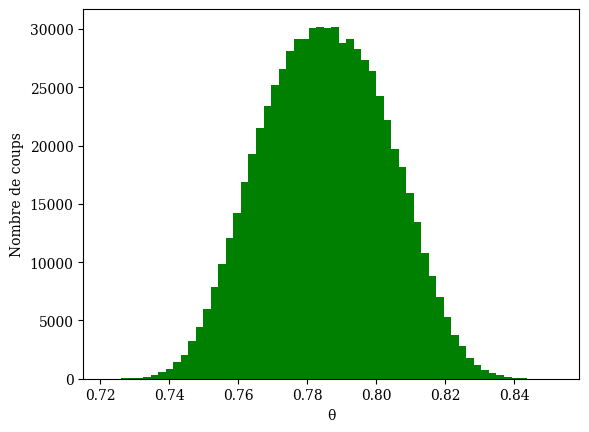

In [24]:
n, bins, patches = plt.hist([i[0] for i in samples], bins=60, color ='green')
#plt.title('Histogramme des données de Métropolis-Hastins pour θ')
plt.xlabel('θ')
plt.ylabel('Nombre de coups')

best_value = []
best_value.append(bins[np.argmax(n)])

print("La valeur obtenue pour θ est : ",  str(best_value[0]))

plt.savefig('Histogramme des valeurs de θ pour ' + str(iterations) + ' iterations')

La valeur obtenue pour theta est :  0.7880096266026219 +- 0.01801103501242858
intervalle de confiance :  0.7500146326973111 0.8206165925946108


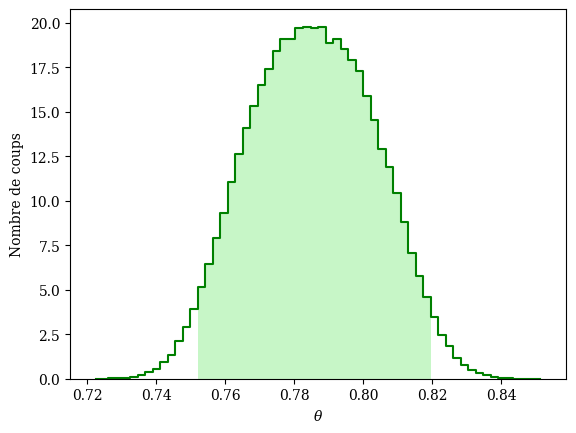

In [25]:
delta_m2_values = [i[0] for i in samples]

n, bins, patches = plt.hist(delta_m2_values, density = True, bins=60, color='white', alpha=0.5)

bin_centers = 0.5 * (bins[:-1] + bins[1:])

confidence_level = 0.95
mean = np.mean(delta_m2_values)
std_dev = np.std(delta_m2_values)
ci_lower = mean - stats.norm.ppf(1 - (1 - confidence_level) / 2) * std_dev
ci_upper = mean + stats.norm.ppf(1 - (1 - confidence_level) / 2) * std_dev

plt.plot(bin_centers, n, drawstyle='steps-mid', color='green', label='Histogramme')


for patch, left, right in zip(patches, bins[:-1], bins[1:]):
    if left >= ci_lower and right <= ci_upper:
        patch.set_facecolor('lightgreen')

plt.xlabel(r'$\theta$')
plt.ylabel('Nombre de coups')
#plt.title('Histogramme des valeurs de Δm² avec intervalle de confiance')

best_value = bin_centers[np.argmax(n)]
print("La valeur obtenue pour theta est : ", best_value, "+-", np.std(delta_m2_values))
print("intervalle de confiance : ", ci_lower, ci_upper)

plt.savefig('Histogramme_des_valeurs_de_theta_pour_{}_iterations_avecIC.png'.format(len(delta_m2_values)))

plt.show()

La valeur obtenue pour Δm² est :  0.002199960424097102 +- 9.241189361150472e-06
intervalle de confiance :  0.0021823989041747055 0.002218623700819045


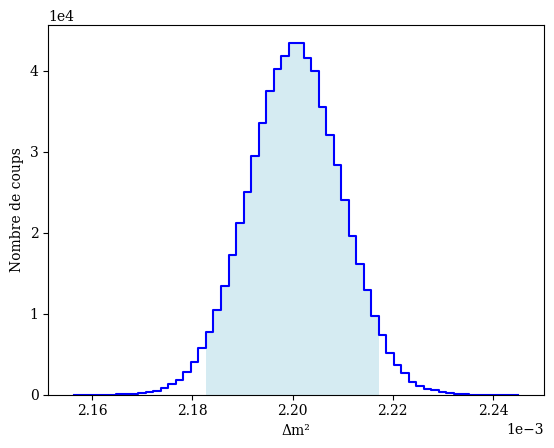

In [47]:
delta_m2_values = [i[1] for i in samples]

n, bins, patches = plt.hist(delta_m2_values, density= True, bins=60, color='white', alpha=0.5)

bin_centers = 0.5 * (bins[:-1] + bins[1:])

confidence_level = 0.95
mean = np.mean(delta_m2_values)
std_dev = np.std(delta_m2_values)
ci_lower = mean - stats.norm.ppf(1 - (1 - confidence_level) / 2) * std_dev
ci_upper = mean + stats.norm.ppf(1 - (1 - confidence_level) / 2) * std_dev

plt.plot(bin_centers, n, drawstyle='steps-mid', color='blue', label='Histogramme')


for patch, left, right in zip(patches, bins[:-1], bins[1:]):
    if left >= ci_lower and right <= ci_upper:
        patch.set_facecolor('lightblue')

plt.xlabel('Δm²')
plt.ylabel('Nombre de coups')
#plt.title('Histogramme des valeurs de Δm² avec intervalle de confiance')

best_value = bin_centers[np.argmax(n)]
print("La valeur obtenue pour Δm² est : ", best_value, "+-", np.std(delta_m2_values))
print("intervalle de confiance : ", ci_lower, ci_upper)

plt.ticklabel_format(axis = 'both', style = 'sci', scilimits=(-3,3))

plt.savefig('Histogramme_des_valeurs_de_Δm²_pour_{}_iterations_avecIC.png'.format(len(delta_m2_values)))

plt.show()

In [27]:
#print("Le plus grand nombre de counts pour theta est :", np.max(hist_theta[0]))
#print("Le plus grand nombre de counts pour Δm² est :", np.max(hist_Dm2[0]))

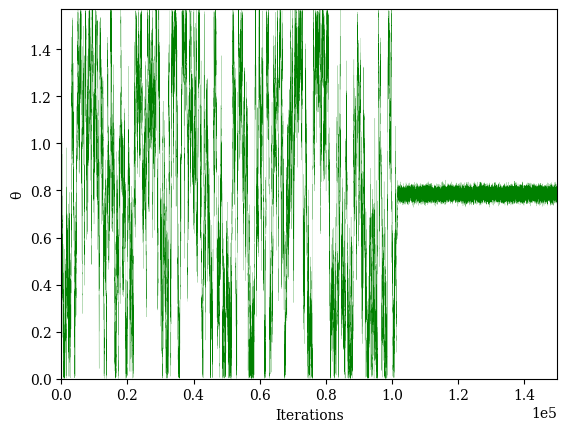

In [49]:
# Trace 
trace_theta = plt.plot([i[0] for i in samples_no_burnin], linestyle = '-', linewidth=0.1, c = 'green')
plt.ticklabel_format(axis='x', style='sci', scilimits=(-3,5))

plt.xlabel('Iterations')
plt.ylabel('θ')
plt.axis([0, 150000, 0, np.pi/2])
#plt.title('Trace de θ')
plt.savefig('trace_theta.png')

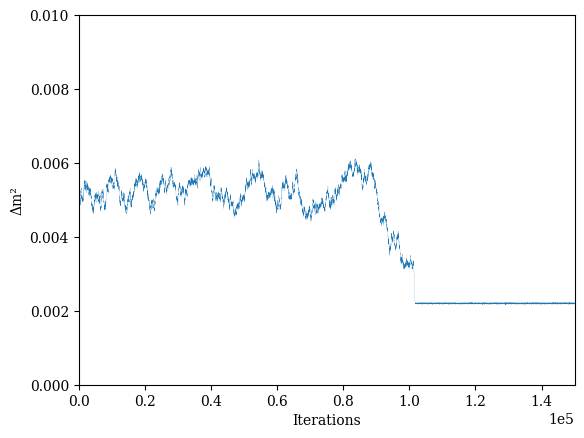

In [51]:
# Trace 
trace_Dm2 = plt.plot([i[1] for i in samples_no_burnin], linestyle = '-', linewidth=0.1, )
plt.xlabel('Iterations')
plt.ylabel('Δm²')
plt.ticklabel_format(axis='both', style='sci', scilimits=(-3,5))
plt.axis([0,150000, 0, 0.01])
plt.savefig('trace_dm2.png')

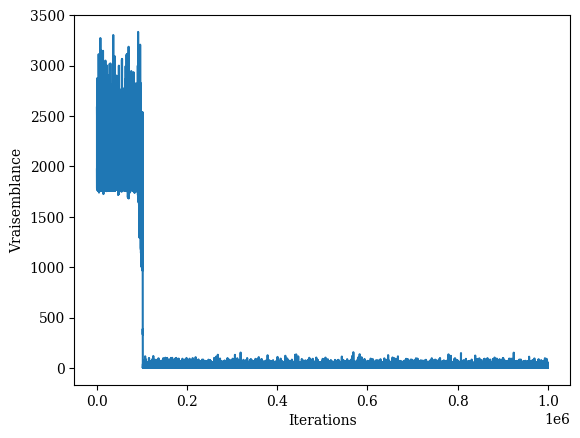

In [30]:
vrais_plot = plt.plot(likelihood_value)
plt.xlabel('Iterations')
plt.ylabel('Vraisemblance')
plt.savefig('Trace_vraisemblance.png')

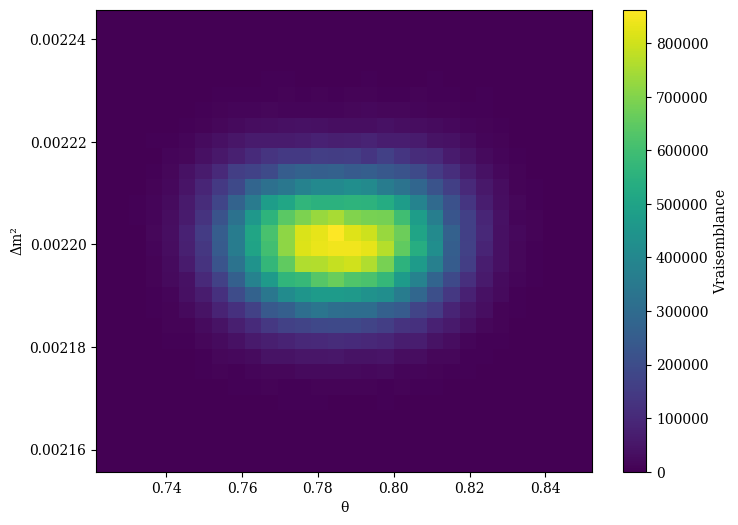

In [31]:
plt.figure(figsize=(8, 6))
heatmap, xedges, yedges, img = plt.hist2d([m[0] for m in samples], [m[1] for m in samples], bins=30, density =True, cmap='viridis')#, range=[[0, 350], [0, 2000]])

# Ajout d'une barre de couleur
plt.colorbar(label='Vraisemblance')

# Titres et labels des axes
plt.xlabel('θ')
plt.ylabel('Δm²')

# Affichage de la heatmap
plt.savefig('Heatmap des valeurs de Δm² et θ pour')
plt.show()


In [32]:
np.savetxt('samples.csv', (samples), delimiter=',')


In [29]:
new_samples = np.genfromtxt('samples.csv', delimiter=',')

La valeur obtenue pour theta est :  0.7880096266026219 +- 0.01801103501242858
intervalle de confiance :  0.7500146326973111 0.8206165925946108


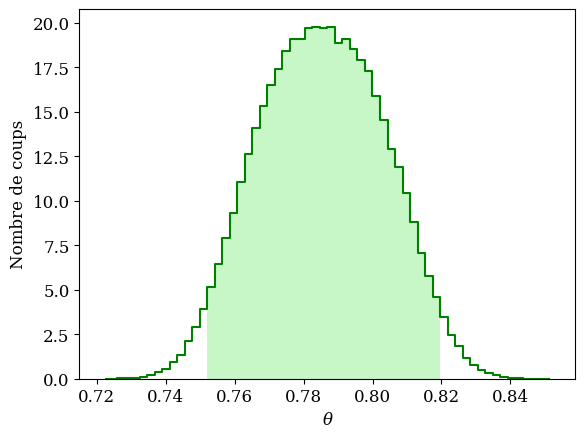

In [20]:
delta_m2_values = [i[0] for i in new_samples]

n, bins, patches = plt.hist(delta_m2_values, density = True, bins=60, color='white', alpha=0.5)

bin_centers = 0.5 * (bins[:-1] + bins[1:])

confidence_level = 0.95
mean = np.mean(delta_m2_values)
std_dev = np.std(delta_m2_values)
ci_lower = mean - stats.norm.ppf(1 - (1 - confidence_level) / 2) * std_dev
ci_upper = mean + stats.norm.ppf(1 - (1 - confidence_level) / 2) * std_dev

plt.plot(bin_centers, n, drawstyle='steps-mid', color='green', label='Histogramme')


for patch, left, right in zip(patches, bins[:-1], bins[1:]):
    if left >= ci_lower and right <= ci_upper:
        patch.set_facecolor('lightgreen')

plt.xlabel(r'$\theta$', fontsize = 12)
plt.ylabel('Nombre de coups', fontsize = 12)
#plt.title('Histogramme des valeurs de Δm² avec intervalle de confiance')

best_value = bin_centers[np.argmax(n)]
print("La valeur obtenue pour theta est : ", best_value, "+-", np.std(delta_m2_values))
print("intervalle de confiance : ", ci_lower, ci_upper)
plt.tick_params(axis = 'both', labelsize = 12)


plt.savefig('Histogramme_des_valeurs_de_theta_pour_{}_iterations_avecIC.png'.format(len(delta_m2_values)))

plt.show()

La valeur obtenue pour Δm² est :  0.002199960424097102 +- 9.241189361150472e-06
intervalle de confiance :  0.0021823989041747055 0.002218623700819045


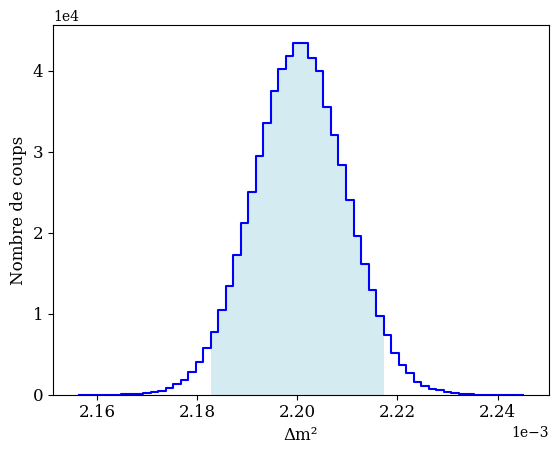

In [22]:
delta_m2_values = [i[1] for i in new_samples]

n, bins, patches = plt.hist(delta_m2_values, density= True, bins=60, color='white', alpha=0.5)

bin_centers = 0.5 * (bins[:-1] + bins[1:])

confidence_level = 0.95
mean = np.mean(delta_m2_values)
std_dev = np.std(delta_m2_values)
ci_lower = mean - stats.norm.ppf(1 - (1 - confidence_level) / 2) * std_dev
ci_upper = mean + stats.norm.ppf(1 - (1 - confidence_level) / 2) * std_dev

plt.plot(bin_centers, n, drawstyle='steps-mid', color='blue', label='Histogramme')


for patch, left, right in zip(patches, bins[:-1], bins[1:]):
    if left >= ci_lower and right <= ci_upper:
        patch.set_facecolor('lightblue')

plt.xlabel('Δm²', fontsize = 12)
plt.ylabel('Nombre de coups', fontsize = 12)
#plt.title('Histogramme des valeurs de Δm² avec intervalle de confiance')

best_value = bin_centers[np.argmax(n)]
print("La valeur obtenue pour Δm² est : ", best_value, "+-", np.std(delta_m2_values))
print("intervalle de confiance : ", ci_lower, ci_upper)

plt.ticklabel_format(axis = 'both', style = 'sci', scilimits=(-3,3))
plt.tick_params(axis = 'both', labelsize = 12)


plt.savefig('Histogramme_des_valeurs_de_Δm²_pour_{}_iterations_avecIC.png'.format(len(delta_m2_values)))

plt.show()

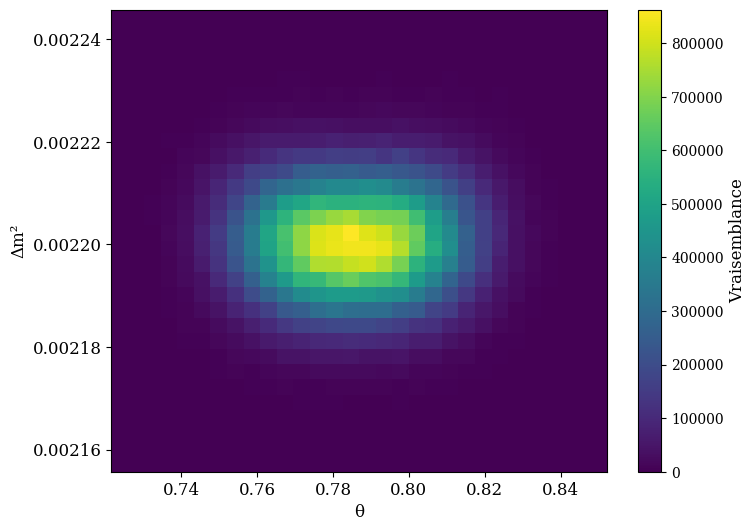

In [32]:
plt.figure(figsize=(8, 6))
heatmap, xedges, yedges, img = plt.hist2d([m[0] for m in new_samples], [m[1] for m in new_samples], bins=30, density =True, cmap='viridis')#, range=[[0, 350], [0, 2000]])

# Ajout d'une barre de couleur
cbar = plt.colorbar(label='Vraisemblance')
cbar.set_label('Vraisemblance', fontsize = 12)

# Titres et labels des axes
plt.xlabel('θ', fontsize = 12)
plt.ylabel('Δm²', fontsize = 12)

plt.tick_params(axis = 'both', labelsize = 12)

# Affichage de la heatmap
plt.savefig('Heatmap des valeurs de Δm² et θ pour')
plt.show()


### 2.3 Acceptance function

The acceptance function is: 
$$ A (\theta_{i}, \Delta m^2_i )=min\{1,r_{i} \} $$
where $r_{i}$ is the Metropolis-Hastings ratio.

**2.3.1 Metropolis-Hastings ratio** 

We compute the Metropolis-Hastings ratio $r_i$ between the posterior probability at this step and at the previous step: 
$$r_i =\frac{P(\theta_i, \Delta m^2_i | D)_{un} \ J(\theta_{i-1}, \Delta m^2_{i-1} | \theta_i, \Delta m^2_{i}) }{P(\theta_{i-1}, \Delta m^2_{i-1} | D)_{un} \ J(\theta_{i}, \Delta m^2_{i} | \theta_{i-1}, \Delta m^2_{i-1})} $$



In [33]:
### Compute the Metropolis-Hastings ratio


**2.3.2 Acceptance function**

The acceptance function returns if the step is accepted or not according to the Metropolis-Hastings ratio $r_i$ and following the properties: 
- $r_i \geq 1 \ \rightarrow $ the step is accepted
- $r_i < 1 \ \rightarrow $: a random number is thrown and: 
    - the step is accepted if  $r_i \geq U(0,1)$ 
    - the step is rejected if $r_i < U(0,1)$



In [34]:
### Compute the acceptance function 


### 2.4 Start the Markov Chain



**2.4.1 Intitialise the chain**

We throw the first step $\theta_0, \Delta m^2_0$ and compute the corresponding posterior probability $P(\theta_0, \Delta m^2_0| D)_{un}$.


In [35]:
### Create container arrays for values


In [36]:
### Throw the first step


**2.4.2 Run the Markov Chain**

We run the Markov Chain for $N=10^6$ steps.

In [37]:
# Run the MCMC


In [38]:
# Save the output in a csv file


## 3. Analyse the Markov Chain output



### 3.1 The trace

The trace is the value of the sampled parameters as a function of the step. We use it to remove the steps sampled before the chained has converged.

In [39]:
### Plot the MCMC trace


In [40]:
### Remove burn-in, i.e. samples before convergence

burnin = 1000

### 3.2 The sampled  distribution

The $\{ \theta_i, \Delta m^2_i \}$ samples are proportional to the posterior distribution $P(\theta,  \Delta m^2 | D)$. 
We will plot their distribution and take the mode as the most probable value.
If the histogram is not smooth enough, is can either been smoothed with an interpolation function or more steps can be added to the chain. 


In [41]:
### Plot the parameters samples - 2D histogram


In [42]:
### Get the mode of the posterior distribution


In [43]:
### Compare the fluxes


In [44]:
theta_proposed = 1.5
Dm2_proposed = 5e-3
ln_likelihood(compute_osc_histo(theta_proposed, Dm2_proposed, evt_rate_unosc))

2509.0778040565187